<a href="https://colab.research.google.com/github/leeswook0503/tmp/blob/main/Fall_armyworm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from IPython.display import Image as ShowImage

# Keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 #16개의 레이어를 제공하는 CNN 아키텍처(사전 훈련된 네트워크로 재사용 가능)
from keras.preprocessing.image import ImageDataGenerator # 실시간 데이터 증식으로 텐서 이미지 데이터의 배치를 생성.(크기 조정, 회전, 확대/축소)
from tensorflow.keras import optimizers
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from google.colab import files
myfile = files.upload()

In [ ]:
# Reading the data
train_labels = pd.read_csv("Train1.csv")
# Show the first 5 rows
train_labels.head()

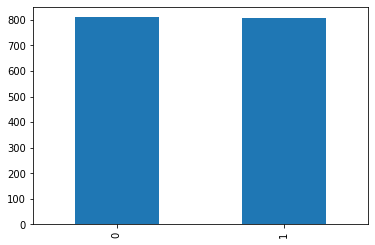

In [ ]:
train_labels['Label'].value_counts().plot.bar()

**가을 거위충에 영향을 받은 옥수수 작물 이미지와 그렇지 않은 이미지 데이터의 수가 비슷**

In [ ]:
from google.colab import files
myfile = files.upload()

Saving Images.zip to Images (1).zip


In [ ]:
# Extracts all the files(압축 해제)
!unzip -q Images.zip

In [ ]:
import cv2
import random
import os
# This stores the location of the data source
data = os.listdir("Images")
# Picking random sample from data list
sample = random.choice(data)
# The imread method loads image from the sprcified file
img = cv2.imread("Images/"+sample)
# The cmap parameter displays the image in gray
plt.imshow(img, cmap="gray")

FileNotFoundError: ignored

In [ ]:
#0과 1을 해충에게 영향을 받았는지 여부로 대체
train_labels["Label"] = train_labels["Label"].replace({0: 'notaffected', 1: 'affected'})

In [ ]:
# Defining how data is passed to the input layer (이미지 데이터가 입력 레이어로 전달되는 방식을 정의)
image_size = 224
input_shape = (image_size, image_size, 3) #(이미지 높이, 이미지 너비, 이미지 채널)
batch_size = 16

In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
# include_top 매개변수는 출력 레이어를 포함할지 여부 결정, VGG16 모델의 출력 레이어가 우리의 분류 문제에 필요하지 않으므로 False
# weights 매개변수는 모델을 초기화할 가중치 체크포인트 지정
# input_shape 매개변수는 네트워크에 입력할 이미지 텐서의 크기

for layer in pre_trained_model.layers[:15]:
  layer.trainable = False
for layer in pre_trained_model.layers[15:]:
  layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output) #GlobalMaxPooling2D - 풀링 크기가 입력 크기와 동일하게 설정되어 전체 입력의 최대값이 출력 값으로 연결되는 또 다른 풀링 유형
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', #이진 분류
optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), #확률적 경사 하강법
metrics=['accuracy']) #분류 문제이기 때문에 정확도로 설정
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1. Input layer - 입력 레이어는 이미지를 읽음. 이미지는 3D 매트릭스로 표시. 치수는 높이, 너비 및 채널. 네트워크가 깊어질수록 너비와 높이가 줄어듦.
2. Convolutional layer - 가장자리와 같은 이미지의 특징이 이 레이어 내에서 추출.
3. Pooling layer - 이 레이어는 이미지 차원 크기를 줄임. 이 계층의 목적은 이미지 크기를 줄여 데이터를 처리할 때 계산 능력을 줄이는 것. 그러면 장기적으로 과적합 가능성이 줄어듦. (MaxPooling2D 레이어를 지날때마다 이미지의 크기가 줄어드는 것을 확인할 수 있음)
4. Fully-connected layer - 이 계층은 훈련을 통해 서로 다른 범주 간의 이미지를 분류. 즉, 컨볼루션 계층의 출력으로 표시되는 고수준 기능의 비선형 조합.
5. Output layer - 최종 레이블을 포함.(0 아니면 1)

In [ ]:
# 조기 종료 구현
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
# ReduceLROnPlateau는 정확도 개선이 중단되었을 때 학습률을 줄이기 위한 콜백
# patience 매개변수는 학습률이 감소한 후 개선되지 않은 에포크의 수
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
# train_test_split 메서드를 이용해 훈련 데이터를 훈련 데이터셋과 검증 데이터셋으로 나눔
from sklearn.model_selection import train_test_split

train_df,validate_df=train_test_split(train_labels,test_size=0.2,random_state=42)
train_df = train_df.reset_index(drop='True')
validate_df = validate_df.reset_index(drop='True')

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
# 실시간 이미지 데이터 증식으로 텐서 이미지 데이터 일괄 생성
from keras.preprocessing.image import ImageDataGenerator, load_img

# Categorical encodes categorical variables (범주형 변수를 인코딩하기 위해)
from tensorflow.keras.utils import to_categorical

In [ ]:
# Here we are formatting the training data (훈련 데이터의 이미지 형식을 지정)
train_datagen = ImageDataGenerator(rotation_range=15,
                                 rescale=1./255,
                                 shear_range=0.1,
                                 zoom_range=0.2, # zoom range (1-0.2 to 1+0.2)
                                 horizontal_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory="images/",
                                                  x_col="image",
                                                  y_col="target",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=15)

# Here we are formatting images on the validation data (검증 데이터의 이미지 형식을 지정)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                  directory="images/",
                                                  x_col="image",
                                                  y_col="target",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=15)

In [ ]:
#훈련 데이터 셋을 이용해 모델을 훈련시키고 이를 100 에포크 동안 실행
epochs=100 
total_validate = validate_df.shape[0]
total_train = train_df.shape[0]
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)
    
# Here we are creating a list of pictures - we are appending images on the list.
# target이라는 빈 리스트를 생성해서 이미지를 추가하여 사진 목록을 생성
# Our data source is the original data before splitting to test and train data
target=[]

for i in data: #이때의 data는 테스트와 훈련 데이터로 분할하기 전의 원본 데이터 셋
    flag=0
    for j in df["image"]:
        if(i==j):
            flag=1
            break;
        else:
            continue
    if(flag==0):    
       target.append(i)

In [ ]:
#creating a test dataframe with images and the target is notaffected for all images
#이미지 데이터를 사용하여 테스트 데이터 프레임을 만들고 target은 모든 이미지에 대해 notaffected 임.
test = pd.DataFrame({
    'image': target,
    'target':"notaffected"
})
test.head()

In [ ]:
#마지막으로 모델을 테스트 데이터에 맞추기 위해 테스트 데이터를 ImageDataGenerator에 전달
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test, 
    directory="images/", 
    x_col="image",
    y_col="target",
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=15,
    shuffle=False)
nb_samples = test.shape[0]
#model.predict_generator는 새로운 이미지 데이터에 대한 예측을 도움.
#np.ceil 메서드는 nb_samples/batch_size의 결과값을 올림
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
# Here we are converting the submission data to a dataframe
# 위에서 예측한 결과를 저장한 predict 객체를 test 데이터 셋의 target 행에 저장.
test["target"]=predict

#here we are converting to a csv file
#test 데이터 셋을 csv 파일로 변환
test.to_csv("submission.csv",index=False)